In [30]:
# import libraries
import polars as pl
import numpy as np
import urllib.request
import os
from pathlib import Path
from datetime import datetime, timedelta
import hvplot.polars
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [31]:
# load CSV
notebook_dir = Path.cwd()
file_path = notebook_dir.parent / "data" / "external" / "FPA_FOD_Plus.csv"

df = pl.read_csv(file_path, infer_schema_length=10000, ignore_errors=True)

# convert DISCOVERY_DATE to datetime
df = df.with_columns(
    pl.col("DISCOVERY_DATE").str.strptime(pl.Date, "%Y-%m-%d").alias("DISCOVERY_DATE")
)

print(df.select("DISCOVERY_DATE").head())
print(f"The number of columns in the dataset: {df.shape[1]}")
print(f"The number of rows in the dataset: {df.shape[0]}")


shape: (5, 1)
┌────────────────┐
│ DISCOVERY_DATE │
│ ---            │
│ date           │
╞════════════════╡
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
└────────────────┘
The number of columns in the dataset: 308
The number of rows in the dataset: 2302521


In [32]:
df_init = df.to_pandas()
# 1. how many columns does the dataset contain?
print(f"The number of columns in the dataset: {df_init.shape[1]}")

# 2. how many rows are there in the dataset?
print(f"The number of rows in the dataset: {df_init.shape[0]}")


The number of columns in the dataset: 308
The number of rows in the dataset: 2302521


In [33]:
# drop columns that have the number of missing values greater than 80%
cutoff_missing_values = df_init.shape[0]*0.8
missing_vals = df_init.isna().sum().sort_values(ascending=False)
cols_missing_gt80pct = list(missing_vals[missing_vals > cutoff_missing_values].index)
df = df_init.drop(columns=cols_missing_gt80pct)

In [34]:
# 1. how many columns does the dataset contain?
print(f"The number of columns in the dataset: {df.shape[1]}")

# 2. how many rows are there in the dataset?
print(f"The number of rows in the dataset: {df.shape[0]}")

# 3. what are the column names?
print(f"Column names int the dataset: {list(df.columns)}")

The number of columns in the dataset: 284
The number of rows in the dataset: 2302521
Column names int the dataset: ['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'LatLong_State', 'LatLong_County', 'NPL', 'Mang_Type', 'Mang_Name', 'Des_Tp', 'GAP_Sts', 'GAP_Prity', 'EVH', 'EVT', 'EVH_1km', 'EVT_1km', 'EVC', 'EVC_1km', 'NAME', 'MOD_NDVI_12m', 'MOD_EVI_12m', 'Land_Cover', 'Land_Cover_1km', 'rpms', 'rpms_1km', 'Population', 'Popo_1km', 'GACCAbbrev', 'GACC_PL', 'GACC_New fire', 'GACC_Type 1 IMTs', 'GACC_Type 2 IMTs', 'GACC_

#### GACC_New LF GACC_New LF are the two missing that shanti/leo have

In [35]:
print("Data types:")
print(df[['FIRE_SIZE_CLASS', 'FIRE_SIZE']].dtypes)

# dscriptive statistics for FIRE_SIZE
print("\nDescriptive statistics for FIRE_SIZE:")
print(df['FIRE_SIZE'].describe())

# counts per FIRE_SIZE_CLASS using value_counts()
print("\nCounts per FIRE_SIZE_CLASS:")
print(df['FIRE_SIZE_CLASS'].value_counts(sort=True))

# missing values
print("\nMissing values summary:")

missing_summary = pd.DataFrame({
    'FIRE_SIZE_CLASS_missing': [df['FIRE_SIZE_CLASS'].isna().sum()],
    'FIRE_SIZE_missing': [df['FIRE_SIZE'].isna().sum()]
})

print(missing_summary.T) 

# percentiles
print("\nFIRE_SIZE percentiles:")

quantiles = [0.25, 0.5, 0.75, 0.95, 0.99]
percentiles = df['FIRE_SIZE'].quantile(quantiles)

# rename the index for clarity
percentiles.index = ['25%', '50% (median)', '75%', '95%', '99%']
print(percentiles.to_frame().T)


Data types:
FIRE_SIZE_CLASS     object
FIRE_SIZE          float64
dtype: object

Descriptive statistics for FIRE_SIZE:
count    2.302521e+06
mean     7.817802e+01
std      2.631077e+03
min      1.000000e-05
25%      1.000000e-01
50%      8.000000e-01
75%      3.000000e+00
max      6.627000e+05
Name: FIRE_SIZE, dtype: float64

Counts per FIRE_SIZE_CLASS:
FIRE_SIZE_CLASS
B    1103730
A     876238
C     256879
D      34003
E      17193
F       9694
G       4784
Name: count, dtype: int64

Missing values summary:
                         0
FIRE_SIZE_CLASS_missing  0
FIRE_SIZE_missing        0

FIRE_SIZE percentiles:
           25%  50% (median)  75%   95%      99%
FIRE_SIZE  0.1           0.8  3.0  45.0  478.048


/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_97519/42213225.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


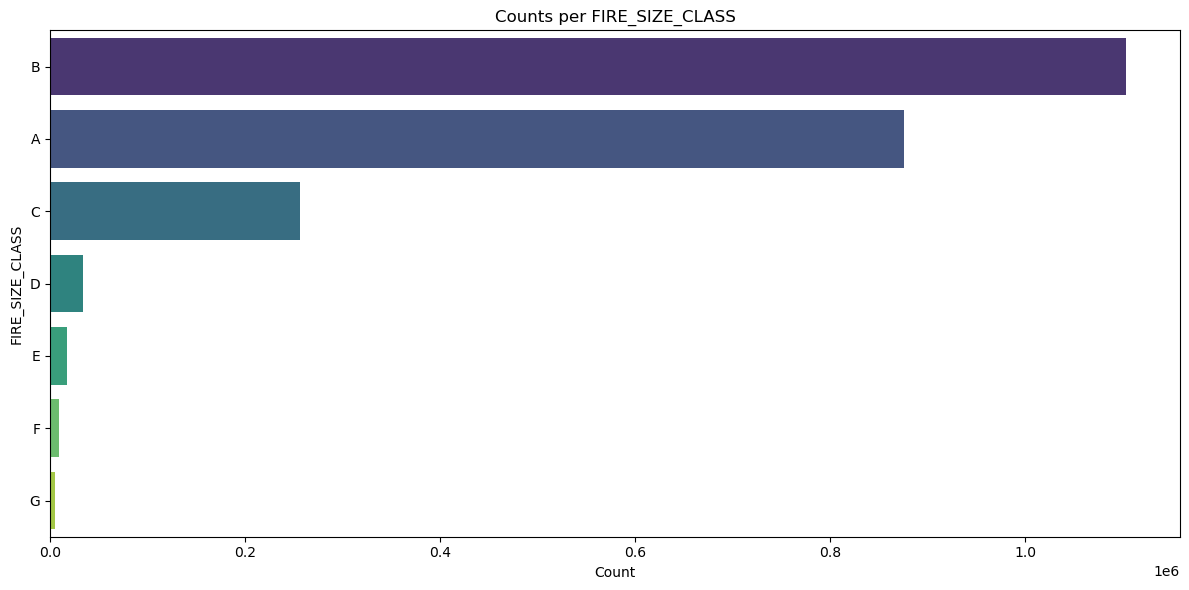

/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_97519/42213225.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


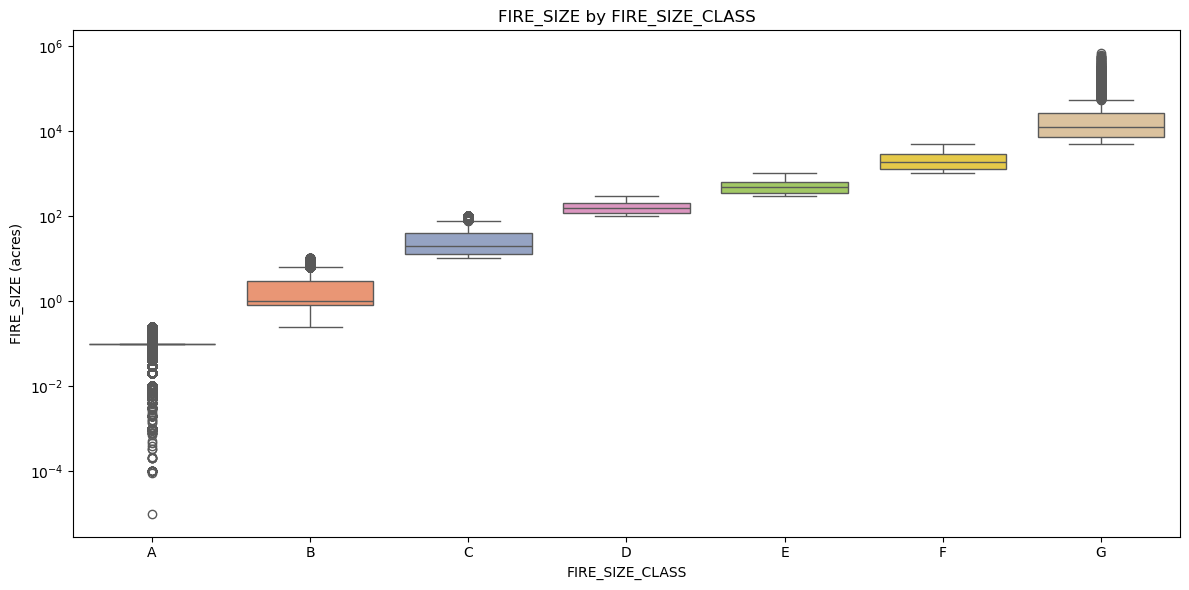

In [36]:
# countplot for FIRE_SIZE_CLASS (categorical)
plt.figure(figsize=(12,6))
sns.countplot(
    data=df,
    y='FIRE_SIZE_CLASS',
    order=df['FIRE_SIZE_CLASS'].value_counts().index,
    palette='viridis'
)
plt.title('Counts per FIRE_SIZE_CLASS')
plt.xlabel('Count')
plt.ylabel('FIRE_SIZE_CLASS')
plt.tight_layout()
plt.show()

# boxplot of FIRE_SIZE by FIRE_SIZE_CLASS
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x='FIRE_SIZE_CLASS',
    y='FIRE_SIZE',
    palette='Set2'
)
plt.title('FIRE_SIZE by FIRE_SIZE_CLASS')
plt.xlabel('FIRE_SIZE_CLASS')
plt.ylabel('FIRE_SIZE (acres)')
plt.yscale('log')  # optional
plt.tight_layout()
plt.show()

In [37]:
# binning approach 4 (from Nedim's code)
bins_04 = [0, 100, 4999, 29000, df.FIRE_SIZE.max()] 
fire_cats_04 = pd.cut(df.FIRE_SIZE, bins_04)
print(f"{fire_cats_04.value_counts()}")
print(f"\n{fire_cats_04.value_counts(normalize=True)}")
group_names = ['small', 'medium', 'large', 'very large']

df['FIRE_SIZE_LABEL'] = pd.cut(df.FIRE_SIZE, bins_04, labels=group_names)

FIRE_SIZE
(0.0, 100.0]           2241807
(100.0, 4999.0]          55930
(4999.0, 29000.0]         3682
(29000.0, 662700.0]       1102
Name: count, dtype: int64

FIRE_SIZE
(0.0, 100.0]           0.973632
(100.0, 4999.0]        0.024291
(4999.0, 29000.0]      0.001599
(29000.0, 662700.0]    0.000479
Name: proportion, dtype: float64


In [38]:
df.FIRE_SIZE_LABEL.value_counts()

FIRE_SIZE_LABEL
small         2241807
medium          55930
large            3682
very large       1102
Name: count, dtype: int64

## Data Pre-Processing

In [39]:
# recode fire_size_label  from string to numeric
firelabel_mapping = {
    'small': 0,
    'medium': 1,
    'large': 2,
    'very large': 3
}
print(f"{firelabel_mapping=}")

df['FIRE_SIZE'] = df['FIRE_SIZE'].map(firelabel_mapping)

firelabel_mapping={'small': 0, 'medium': 1, 'large': 2, 'very large': 3}


In [40]:
print(f"Column names int the dataset: {list(df.columns)}")

Column names int the dataset: ['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'LatLong_State', 'LatLong_County', 'NPL', 'Mang_Type', 'Mang_Name', 'Des_Tp', 'GAP_Sts', 'GAP_Prity', 'EVH', 'EVT', 'EVH_1km', 'EVT_1km', 'EVC', 'EVC_1km', 'NAME', 'MOD_NDVI_12m', 'MOD_EVI_12m', 'Land_Cover', 'Land_Cover_1km', 'rpms', 'rpms_1km', 'Population', 'Popo_1km', 'GACCAbbrev', 'GACC_PL', 'GACC_New fire', 'GACC_Type 1 IMTs', 'GACC_Type 2 IMTs', 'GACC_NIMO Teams', 'GACC_Area Command Teams', 'GACC_Fire Use Teams', 'GDP', 'pr_Normal', 't

In [41]:
np.random.seed(207)

indices = list(range(df.shape[0]))
shuffled_indices = np.random.permutation(indices)
df = df.reindex(index=shuffled_indices)

In [42]:
val_size = 0.2/(0.2 + 0.6)
df_train_main, df_test = train_test_split(df, test_size= 0.2, random_state=207,
                                           stratify=list(zip(df['FIRE_YEAR'], df['FIRE_SIZE_LABEL'])))
df_train, df_val = train_test_split(df_train_main, test_size=val_size, random_state=207,
                                     stratify=list(zip(df_train_main['FIRE_YEAR'], df_train_main['FIRE_SIZE_LABEL'])))

# print shapes
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (1381512, 285)
Shape of df_val: (460504, 285)
Shape of df_test: (460505, 285)


In [43]:
# from FPA FOD data
trgt_feat_fod = ['FIRE_SIZE_LABEL', 'FIRE_YEAR', 'DISCOVERY_DOY', 'NWCG_CAUSE_CLASSIFICATION', 'LATITUDE', 'LONGITUDE']

# from GRIDMET: variables surround 5-day window centered on the fire discovery date
feat_gridmet = list(df_train.columns[df_train.columns.str.contains('_5D_')])

# from risk management assistance
feat_rmgmta = ['SDI']

# from fire stations
feat_firestation = ['No_FireStation_20.0km']

# from GACC
feat_gacc = ['GACC_PL']

# from global human modification
feat_ghm = ['GHM']

# from NDVI
feat_ndvi = ['NDVI-1day']      

# from national preparedness level
feat_npl = ['NPL']

# from social vulnerability index
feat_svi = ['EPL_PCI']

# from rangeland prod
feat_rangeland = ['rpms', 'rpms_1km']

In [44]:
# compile selected vars
trgt_feat_selected = trgt_feat_fod + feat_gridmet + feat_rmgmta + feat_firestation + feat_gacc + feat_ghm + feat_ndvi + feat_npl + feat_svi + feat_rangeland
# select only variables of interest (outcome and features)
df_train = df_train[trgt_feat_selected]
df_val = df_val[trgt_feat_selected]
df_test = df_test[trgt_feat_selected]

# print shapes
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (1381512, 46)
Shape of df_val: (460504, 46)
Shape of df_test: (460505, 46)


In [45]:
# check for missing value
df_train.isna().sum().sort_values(ascending=False)

GACC_PL                      710043
EPL_PCI                       59194
NDVI-1day                     45772
rmin_5D_mean                  28581
sph_5D_mean                   28581
rmax_5D_mean                  28581
vs_5D_mean                    28581
th_5D_mean                    28581
etr_5D_mean                   28581
bi_5D_mean                    28581
srad_5D_mean                  28581
tmmx_5D_mean                  28581
tmmn_5D_mean                  28581
pr_5D_mean                    28581
th_5D_max                     28581
vs_5D_max                     28581
sph_5D_min                    28581
srad_5D_max                   28581
bi_5D_max                     28581
etr_5D_max                    28581
fm100_5D_mean                 28581
fm1000_5D_mean                28581
pr_5D_max                     28581
tmmn_5D_max                   28581
tmmx_5D_max                   28581
rmin_5D_min                   28581
rmax_5D_min                   28581
vpd_5D_mean                 

In [46]:
def impute_with_zero(df):
    """Impute the missing values in selected columns with zero

    Args:
     - df: a data frame

    Return:
    - df: a data frame 
    """

    # vars impute with zero
    cols_impute_zero = ['No_FireStation_20.0km', 'GACC_PL']

    for column in cols_impute_zero:
        df[column] = df[column].fillna(0)
    
    return df

In [47]:
# selected vars: impute missing values with zero
df_train = impute_with_zero(df_train)
df_val = impute_with_zero(df_val)
df_test = impute_with_zero(df_test)

In [48]:
# selected vars: impute with missing values the mean

# replace value of -999.0 (the only value less than 0) in EPL_PCI as missing values
for data in [df_train, df_val, df_test]:
    data['EPL_PCI'] = data['EPL_PCI'].replace(-999, np.nan)

cols_impute_mean = feat_gridmet + ['SDI', 'EPL_PCI', 'NDVI-1day']

imp_x = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_train[cols_impute_mean])
df_val[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_val[cols_impute_mean])
df_test[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_test[cols_impute_mean])

In [49]:
# sanity check for missing value 
df_train.isna().sum().sort_values(ascending=False)

FIRE_SIZE_LABEL              0
FIRE_YEAR                    0
DISCOVERY_DOY                0
NWCG_CAUSE_CLASSIFICATION    0
LATITUDE                     0
LONGITUDE                    0
pr_5D_mean                   0
tmmn_5D_mean                 0
tmmx_5D_mean                 0
rmin_5D_mean                 0
rmax_5D_mean                 0
sph_5D_mean                  0
vs_5D_mean                   0
th_5D_mean                   0
srad_5D_mean                 0
etr_5D_mean                  0
fm100_5D_mean                0
fm1000_5D_mean               0
bi_5D_mean                   0
vpd_5D_mean                  0
erc_5D_mean                  0
pr_5D_min                    0
pr_5D_max                    0
tmmn_5D_max                  0
tmmx_5D_max                  0
rmin_5D_min                  0
rmax_5D_min                  0
sph_5D_min                   0
vs_5D_max                    0
th_5D_max                    0
srad_5D_max                  0
etr_5D_max                   0
fm100_5D

In [50]:
nwcg_cause_simplified = {
    'Human' : 'hum',
    'Natural' : 'nat',
    'Missing data/not specified/undetermined' : 'miss-unspec'
    
}

for data in [df_train, df_val, df_test]:
    data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].map(nwcg_cause_simplified)

In [51]:
df_train['NWCG_CAUSE_CLASSIFICATION'].value_counts(dropna=False) # sanity check

NWCG_CAUSE_CLASSIFICATION
hum            1069602
nat             195896
miss-unspec     116014
Name: count, dtype: int64

In [52]:
# one-hot encoding
cols_onehot = ['NWCG_CAUSE_CLASSIFICATION', 'GACC_PL']
df_train = pd.get_dummies(df_train, columns=cols_onehot)
df_val = pd.get_dummies(df_val, columns=cols_onehot)
df_test = pd.get_dummies(df_test, columns=cols_onehot)

In [ ]:
# define outcome
Y_train = df_train['FIRE_SIZE_LABEL']
Y_val = df_val['FIRE_SIZE_LABEL']
Y_test = df_test['FIRE_SIZE_LABEL']

print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of Y_train: (1381512,)
Shape of Y_val: (460504,)
Shape of Y_test: (460505,)


In [54]:
# define features
features = list(df_train.columns)
print(f"Number of items in features before removing outcome: {len(features)}")
features.remove('FIRE_SIZE_LABEL')
print(f"Number of items in features before removing outcome: {len(features)}")
print(f"{features=}")

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Number of items in features before removing outcome: 53
Number of items in features before removing outcome: 52
features=['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'pr_5D_mean', 'tmmn_5D_mean', 'tmmx_5D_mean', 'rmin_5D_mean', 'rmax_5D_mean', 'sph_5D_mean', 'vs_5D_mean', 'th_5D_mean', 'srad_5D_mean', 'etr_5D_mean', 'fm100_5D_mean', 'fm1000_5D_mean', 'bi_5D_mean', 'vpd_5D_mean', 'erc_5D_mean', 'pr_5D_min', 'pr_5D_max', 'tmmn_5D_max', 'tmmx_5D_max', 'rmin_5D_min', 'rmax_5D_min', 'sph_5D_min', 'vs_5D_max', 'th_5D_max', 'srad_5D_max', 'etr_5D_max', 'fm100_5D_min', 'fm1000_5D_min', 'bi_5D_max', 'vpd_5D_max', 'erc_5D_max', 'SDI', 'No_FireStation_20.0km', 'GHM', 'NDVI-1day', 'NPL', 'EPL_PCI', 'rpms', 'rpms_1km', 'NWCG_CAUSE_CLASSIFICATION_hum', 'NWCG_CAUSE_CLASSIFICATION_miss-unspec', 'NWCG_CAUSE_CLASSIFICATION_nat', 'GACC_PL_0.0', 'GACC_PL_1.0', 'GACC_PL_2.0', 'GACC_PL_3.0', 'GACC_PL_4.0', 'GACC_PL_5.0']

Shape of X_train: (1381512, 52)
Shape of X_val: (460504, 52)
Shape of X_tes

In [55]:
print(f"Original class distribution, training data:\n{Y_train.value_counts()}")

Original class distribution, training data:
FIRE_SIZE_LABEL
small         1345081
medium          33560
large            2211
very large        660
Name: count, dtype: int64


In [56]:
# apply SMOTE to the training data
smote = SMOTE(random_state=207)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print(f"Class distribution after SMOTE, training data:\n{Y_train_resampled.value_counts()}")

Class distribution after SMOTE, training data:
FIRE_SIZE_LABEL
small         1345081
medium        1345081
large         1345081
very large    1345081
Name: count, dtype: int64


In [57]:
# exclude one-hot-encoded vars from later standardization
cols_ncwg = list(X_train_resampled.columns[X_train_resampled.columns.str.contains('NWCG_CAUSE_CLASSIFICATION')])
cols_gacc = list(X_train_resampled.columns[X_train_resampled.columns.str.contains('GACC_PL')])
cols_onehot = cols_ncwg + cols_gacc
cols_continuous = [item for item in list(X_train_resampled.columns) if item not in cols_onehot]

X_train_res_continuous = X_train_resampled[cols_continuous]
X_train_res_onehot = X_train_resampled[cols_onehot]
X_val_continuous = X_val[cols_continuous]
X_val_onehot = X_val[cols_onehot]
X_test_continuous = X_test[cols_continuous]
X_test_onehot = X_test[cols_onehot]

# standardized continuous features
sc_x = StandardScaler()

X_train_res_cont_std = sc_x.fit(X_train_res_continuous).transform(X_train_res_continuous)
X_val_cont_std = sc_x.fit(X_train_res_continuous).transform(X_val_continuous)
X_test_cont_std = sc_x.fit(X_train_res_continuous).transform(X_test_continuous)

# add one-hot-encoded vars back 
X_train_res_std = np.concatenate((X_train_res_cont_std, X_train_res_onehot), axis= 1)
X_val_std = np.concatenate((X_val_cont_std, X_val_onehot), axis= 1)
X_test_std = np.concatenate((X_test_cont_std, X_test_onehot), axis= 1)